In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import joblib
import os


%matplotlib inline

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './ai-moderator-b18e81abdc4a.json'

#### Constants

In [4]:
RANDOM_SEED = 42
DICT_SIZE = 10000
TEST_SIZE = 10000
DEV_SIZE = 10000
PATH = '/communities/default/versions/char-cnn/'

TRAIN = False
UPLOAD = False

## Preparations

TODO: Make pip python package `GoogleCloudStorageWrapper`

In [8]:
import base64
import hashlib
from os import path

from google.api_core import exceptions as g_exceptions
from google.cloud import storage as g_storage


class GoogleCloudStorageWrapper:
    @staticmethod
    def md5_base64(filename):
        """Returns md5 hash with base of 64"""
        hash_md5 = hashlib.md5()
        with open(filename, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        hash_md5_base64 = base64.b64encode(hash_md5.digest()).decode('utf-8')
        return hash_md5_base64

    @staticmethod
    def lazy_upload_blob(bucket_name, source_file_name, destination_blob_name):
        """Uploads a file to the bucket if it has different hash."""
        storage_client = g_storage.Client()
        bucket = storage_client.get_bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        remote_blob = bucket.get_blob(destination_blob_name)

        local_md5 = GoogleCloudStorageWrapper.md5_base64(source_file_name)

        if remote_blob is not None:
            remote_md5 = remote_blob.md5_hash
            if remote_md5 == local_md5:
#                 print(f'Blob `{destination_blob_name} is '
#                       f'already in bucket `{bucket_name}`')
                return

#             print(f'Updating blob `{destination_blob_name}` in '
#                   f'bucket `{bucket_name}` from `{source_file_name}`')

        blob.upload_from_filename(source_file_name)

        # check for integrity of uploaded file
        uploaded_blob = bucket.get_blob(destination_blob_name)
        uploaded_md5 = uploaded_blob.md5_hash
        if uploaded_md5 != local_md5:
            raise g_exceptions.DataLoss('Downloaded file differs from remote')

#         print(f'File `{source_file_name}` successfully uploaded '
#               f'to `{destination_blob_name}` of bucket `{bucket_name}`')

    @staticmethod
    def lazy_download_blob(bucket_name, source_blob_name, destination_file_name):
        """Downloads a blob from the bucket if the local version of file differs
        from the remote version (calculated using md5 hash)."""

        storage_client = g_storage.Client()
        bucket = storage_client.get_bucket(bucket_name)
        blob = bucket.blob(source_blob_name)
        remote_blob = bucket.get_blob(source_blob_name)

        remote_md5 = remote_blob.md5_hash

        if path.exists(destination_file_name):
            local_md5 = GoogleCloudStorageWrapper.md5_base64(destination_file_name)
            if remote_md5 == local_md5:
#                 print(f'Blob {source_blob_name} is already downloaded to {destination_file_name}')
                return

        blob.download_to_filename(destination_file_name)

        # check for integrity of downloaded file
        downloaded_md5 = GoogleCloudStorageWrapper.md5_base64(destination_file_name)
        if remote_md5 != downloaded_md5:
            raise g_exceptions.DataLoss('Downloaded file differs from remote')

#         print(f'Blob {source_blob_name} successfully downloaded to {destination_file_name}')


Create temporary folder for files

In [9]:
if not os.path.exists('./temp-files/'):
    os.mkdir('./temp-files/')

Download dataset from google cloud.

In [10]:
GoogleCloudStorageWrapper.lazy_download_blob(bucket_name='communities-models',
                                             source_blob_name='/data/toxic-comment/core.csv',
                                             destination_file_name='./temp-files/core.csv')

Load dataset

In [11]:
core = pd.read_csv("./temp-files/core.csv")
core.loc[:, 'comment_text'] = core.loc[:, 'comment_text'].str.lower()
core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
id              159571 non-null object
comment_text    159571 non-null object
base_class      159571 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [12]:
core = core.assign(len=core['comment_text'].str.len())
core.head(2)

,id,comment_text,base_class,len
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,264
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,112


In [13]:
train, test = model_selection.train_test_split(core, test_size=(TEST_SIZE + DEV_SIZE), random_state=RANDOM_SEED,
                                               stratify=core.loc[:, 'base_class'])
dev, test = model_selection.train_test_split(test, test_size=TEST_SIZE, random_state=RANDOM_SEED,
                                             stratify=test.loc[:, 'base_class'])
print(len(train), len(test), len(dev))
train.head(3)

139571 10000 10000


,id,comment_text,base_class,len
62257,a696d526522491f3,", i agree, but until yesterday i was simply st...",0,258
53024,8db3c98f026f4df8,"""\n agree with gamaliel. i don't see any harm ...",0,143
14787,270e407e9efd6c28,"""\n\nspeedy deletion of the wrong trousers (ba...",0,1291


CNN requires to limit the length of the message by the selected amount of letter, so take a look into dataset to select the amount of letters to use

In [14]:
import matplotlib.pyplot as plt

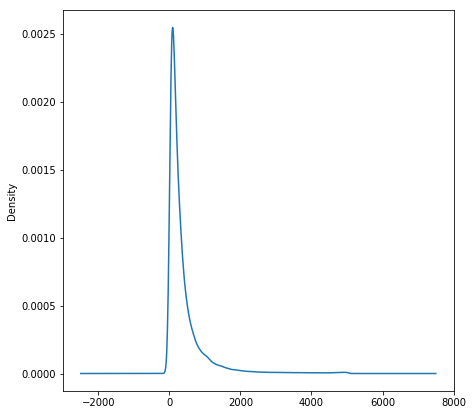

In [15]:
plt.figure(figsize=(7,7))
core['len'].plot.kde()

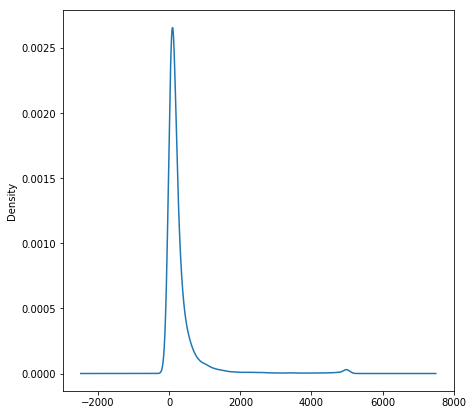

In [16]:
plt.figure(figsize=(7,7))
core.loc[core['base_class'] == 1, 'len'].plot.kde()

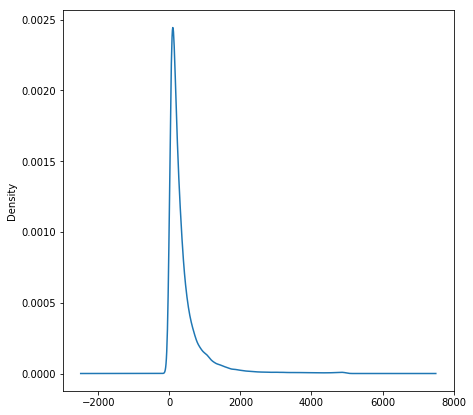

In [17]:
plt.figure(figsize=(7,7))
core.loc[core['base_class'] == 0, 'len'].plot.kde()

looks like most of messages fits into 1500-2000 range  
let's check it

In [18]:
core['len'].quantile(q=0.95)

1355.0

95% of messages fits in 1353 letters

---

In [19]:
core.loc[core['base_class'] == 1, 'len'].quantile(q=0.95)

1021.0

95% of toxic messages fits in about 1000 letters

---

In [20]:
core.loc[core['base_class'] == 0, 'len'].quantile(q=0.95)

1386.0

95% of correct messages fits in about 1400 letters

---

This means that we can cut our messages on about 1500 letters without having much information lost

In [21]:
MESSAGE_LEN_CHAR = 1500

## Juicy part

In [22]:
VOCAB_SIZE=256

In [23]:
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence

In [24]:
if TRAIN:
    #=======================Convert string to index================
    # Tokenizer
    tokenizer = text.Tokenizer(num_words=VOCAB_SIZE, char_level=True, oov_token='UNK', split='', lower=True)
    tokenizer.fit_on_texts(train['comment_text'])

In [25]:
if TRAIN:
    # Convert string to index 
    train_sequences = tokenizer.texts_to_sequences(train['comment_text'])

    # Padding sequences
    train_data = sequence.pad_sequences(train_sequences, maxlen=MESSAGE_LEN_CHAR, padding='post')

## Model

In [26]:
from tensorflow.keras import layers # Input, Embedding, Activation, Flatten, Dense
                                    # Conv1D, MaxPooling1D, Dropout
from tensorflow.keras import models # Model

In [27]:
EMBEDDING_SIZE = 50
             # filters_num, filters_size, pooling_size
conv_layers = [[4, 7, 3 ], 
               [8, 7, 3 ], 
               [16, 3, -1], 
               [32, 3, -1], 
               [64, 3, -1], 
               [128, 3, 3 ]]

fully_connected_layers = [15]
dropout_p = 0.5

In [28]:
if TRAIN:
    # Input
    inputs = layers.Input(shape=(MESSAGE_LEN_CHAR,), name='input', dtype='int32')

    # Embedding layer Initialization
    x = layers.Embedding(input_dim=(VOCAB_SIZE + 1),
                         output_dim=EMBEDDING_SIZE,
                         input_length=MESSAGE_LEN_CHAR)(inputs)

    # Conv
    for filter_num, filter_size, pooling_size in conv_layers:
        x = layers.Conv1D(filter_num, filter_size)(x) 
        x = layers.Activation('relu')(x)
        if pooling_size != -1:
            x = layers.MaxPooling1D(pool_size=pooling_size)(x)

    # Move to fully-connected layer
    x = layers.Flatten()(x)

    for dense_size in fully_connected_layers:
        x = layers.Dense(dense_size, activation='relu')(x) # dense_size == 1024
        x = layers.Dropout(rate=dropout_p)(x)


    # Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    # Build model
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

In [29]:
if TRAIN:
    training_successfully_finished = False
    model.fit(train_data, train['base_class'],
              batch_size=32,
              epochs=10,
              verbose=2)
    training_successfully_finished = True

    if training_successfully_finished:
        joblib.dump(tokenizer, './temp-files/tokenizer.joblib')
        model.save("./temp-files/model.h5", overwrite=True)

        if UPLOAD:
            GoogleCloudStorageWrapper.lazy_upload_blob(bucket_name='communities-models',
                                                       source_file_name='./temp-files/tokenizer.joblib',
                                                       destination_blob_name=PATH + 'tokenizer.joblib')
            GoogleCloudStorageWrapper.lazy_upload_blob(bucket_name='communities-models',
                                                       source_file_name='./temp-files/model.h5',
                                                       destination_blob_name=PATH + 'model.h5')

## Model evaluation

In [30]:
GoogleCloudStorageWrapper.lazy_download_blob(bucket_name='communities-models',
                                             source_blob_name=PATH + 'tokenizer.joblib',
                                             destination_file_name='./temp-files/tokenizer.joblib')
GoogleCloudStorageWrapper.lazy_download_blob(bucket_name='communities-models',
                                             source_blob_name=PATH + 'model.h5',
                                             destination_file_name='./temp-files/model.h5')

In [31]:
model = models.load_model("./temp-files/model.h5")
tokenizer = joblib.load('./temp-files/tokenizer.joblib')

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [32]:
from sklearn import metrics

In [33]:
dev_ready = sequence.pad_sequences(
    tokenizer.texts_to_sequences(dev['comment_text']), maxlen=MESSAGE_LEN_CHAR
)

In [34]:
predicted_probas = model.predict(dev_ready, verbose=1).squeeze()

10000/10000 [==============================] - 3s 268us/step


In [35]:
predicted = (predicted_probas > 0.5).astype(int)
real = dev.loc[:, 'base_class']

##### Single number metrics

* Accuracy

In [36]:
acc = metrics.accuracy_score(predicted, real)
acc

0.9234

* Balanced accuracy

In [37]:
b_acc = metrics.balanced_accuracy_score(predicted, real)
b_acc

0.9272177761166085

* ROC-AUC

In [38]:
roc_auc = metrics.roc_auc_score(real, predicted_probas)
roc_auc

0.863059317441193

##### Confusion matrix

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 33.0, 'Predicted label')

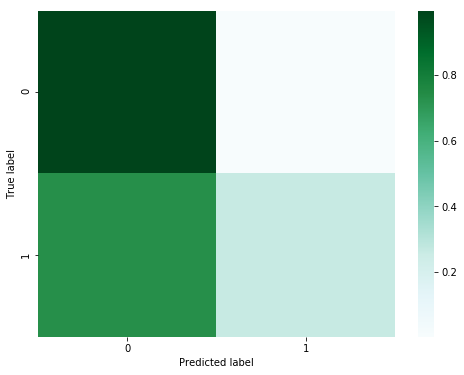

In [41]:
confusion_matrix = metrics.confusion_matrix(real, predicted)
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
# cm_df = pd.DataFrame(confusion_matrix, index=[], columns=[])
plt.figure(figsize=(8, 6))
_ = sns.heatmap(confusion_matrix, cmap='BuGn')
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### Curves

* ROC

In [42]:
def plot_roc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

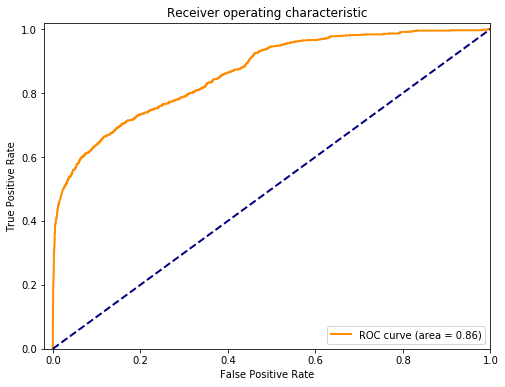

In [43]:
fpr, tpr, thresholds_roc = metrics.roc_curve(real, predicted_probas)
plot_roc(fpr, tpr)

* precision recall curve

In [44]:
def plot_prc(precision, recall):
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(precision, recall, color='darkorange', lw=lw, label='PR curve')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.02])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

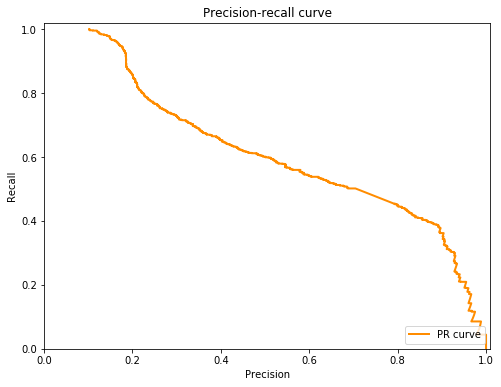

In [45]:
prec, rec, thresholds_prc = metrics.precision_recall_curve(real, predicted_probas)
plot_prc(prec, rec)